In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Prophet is an addtive time series forecasting model developed by Facebook.

In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
import requests
from bs4 import BeautifulSoup
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings;
warnings.filterwarnings("ignore")

In [ ]:
url = "https://www.cbr.ru/eng/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=05.01.2024"

data = requests.get(url).text
beautiful_soup = BeautifulSoup(data, "html.parser")
tables = beautiful_soup.find_all("table")
df = pd.read_html(str(tables))[0]
df.iloc[:, 1:] /= 100 #iloc takes all rows and all columns (columns starting from second column!) + /= 100 divides all rows by 100


In [ ]:
df

,Date,Rate
0,05.01.2024,0.160
1,04.01.2024,0.160
2,03.01.2024,0.160
3,29.12.2023,0.160
4,28.12.2023,0.160
...,...,...
2568,23.09.2013,0.055
2569,20.09.2013,0.055
2570,19.09.2013,0.055
2571,18.09.2013,0.055


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2573 entries, 0 to 2572
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2573 non-null   object 
 1   Rate    2573 non-null   float64
dtypes: float64(1), object(1)
memory usage: 40.3+ KB


In [ ]:
df.Date = pd.to_datetime(df.Date.astype(str), format = "%d.%m.%Y")
df

,Date,Rate
0,2024-01-05,0.160
1,2024-01-04,0.160
2,2024-01-03,0.160
3,2023-12-29,0.160
4,2023-12-28,0.160
...,...,...
2568,2013-09-23,0.055
2569,2013-09-20,0.055
2570,2013-09-19,0.055
2571,2013-09-18,0.055


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2573 entries, 0 to 2572
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2573 non-null   datetime64[ns]
 1   Rate    2573 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.3 KB


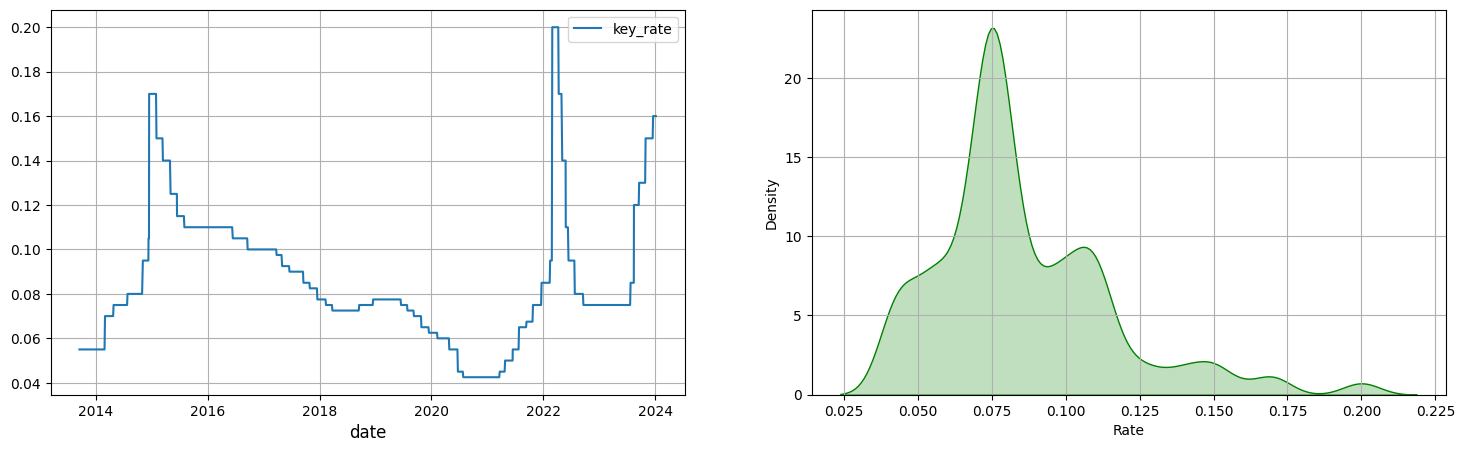

In [ ]:
fig, axes = plt.subplots(1, 2 , figsize = (18, 5))

axes[0].plot(df.Date, df.Rate, label = "key_rate")
axes[0].set_xlabel("date", fontsize = 12)
axes[0].legend(loc = "best")
axes[0].grid(True)



sns.kdeplot(df.Rate, ax = axes[1], color = "green", fill = True)
axes[1].grid(True)
plt.show()

In [ ]:
def create_features(data_full, col_datetime):
  data = data_full.copy()
  data["weekday"] = data[col_datetime].dt.day_name().astype(cat_type)
  data["quarter"] = data["Date"].dt.quarter
  data["month"] = data[col_datetime].dt.month
  data["year"] = data[col_datetime].dt.year
  data["date_offset"] = (data[col_datetime].dt.month * 100 + data.Date.dt.day - 320) % 1300
  data["season"] = pd.cut(data["date_offset"], [0, 300, 602, 900, 1300], labels = ["spring", "summer", "autumn", "winter"])

  return data

cat_type = CategoricalDtype(categories = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered = True)

df_features = create_features(data_full = df, col_datetime = "Date")


In [ ]:
df_features

,Date,Rate,weekday,quarter,month,year,date_offset,season
0,2024-01-05,0.160,Friday,1,1,2024,1085,winter
1,2024-01-04,0.160,Thursday,1,1,2024,1084,winter
2,2024-01-03,0.160,Wednesday,1,1,2024,1083,winter
3,2023-12-29,0.160,Friday,4,12,2023,909,winter
4,2023-12-28,0.160,Thursday,4,12,2023,908,winter
...,...,...,...,...,...,...,...,...
2568,2013-09-23,0.055,Monday,3,9,2013,603,autumn
2569,2013-09-20,0.055,Friday,3,9,2013,600,summer
2570,2013-09-19,0.055,Thursday,3,9,2013,599,summer
2571,2013-09-18,0.055,Wednesday,3,9,2013,598,summer


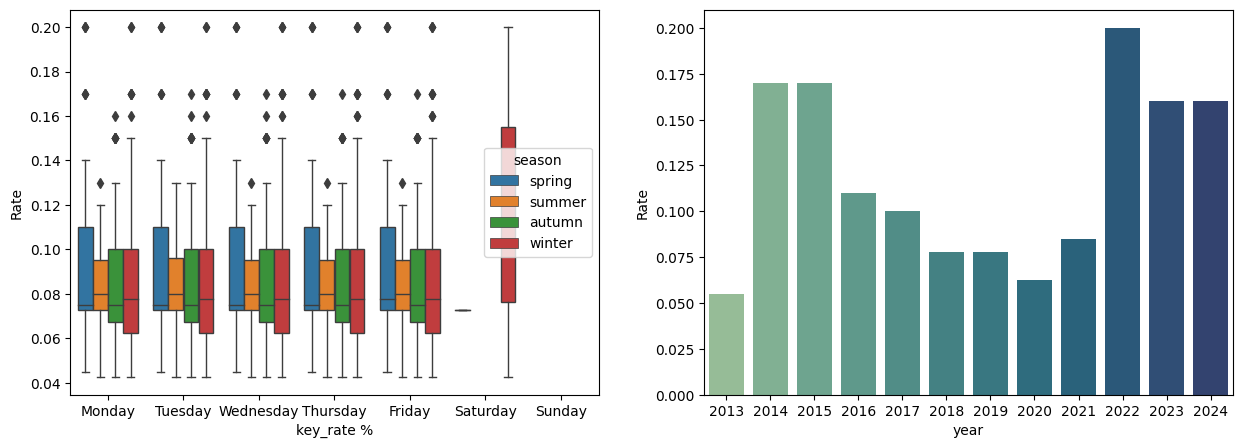

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

sns.boxplot(data = df_features,
            x = "weekday",
            y = "Rate",
            hue = "season",
            ax = axes[0],
            linewidth = 1)
axes[0].set_xlabel("weekday")
axes[0].set_xlabel("key_rate %")

yearAggr = pd.DataFrame(df_features.groupby("year")["Rate"].max()).reset_index().sort_values("Rate")

sns.barplot(data = yearAggr, x = "year", y = "Rate", palette = "crest")
plt.show()

In [ ]:
df_features[df_features.weekday == "Saturday"]

,Date,Rate,weekday,quarter,month,year,date_offset,season
464,2022-03-05,0.2000,Saturday,1,3,2022,1285,winter
728,2021-02-20,0.0425,Saturday,1,2,2021,1200,winter
1404,2018-06-09,0.0725,Saturday,2,6,2018,289,spring
1431,2018-04-28,0.0725,Saturday,2,4,2018,108,spring
1971,2016-02-20,0.1100,Saturday,1,2,2016,1200,winter


In [ ]:
drop_idx = df_features[df_features.weekday == "Saturday"].index
df = df[~df.index.isin(drop_idx)]
df = df.reset_index(drop = True)

In [ ]:
df.columns = ["ds", "y"]
df = df.sort_values(by="ds")
SIZE = int(df.shape[0]*0.1)

train_df = df.iloc[:-SIZE]
test_df = df.iloc[-SIZE:]

print(train_df.shape)
print(test_df.shape)

(2312, 2)
(256, 2)


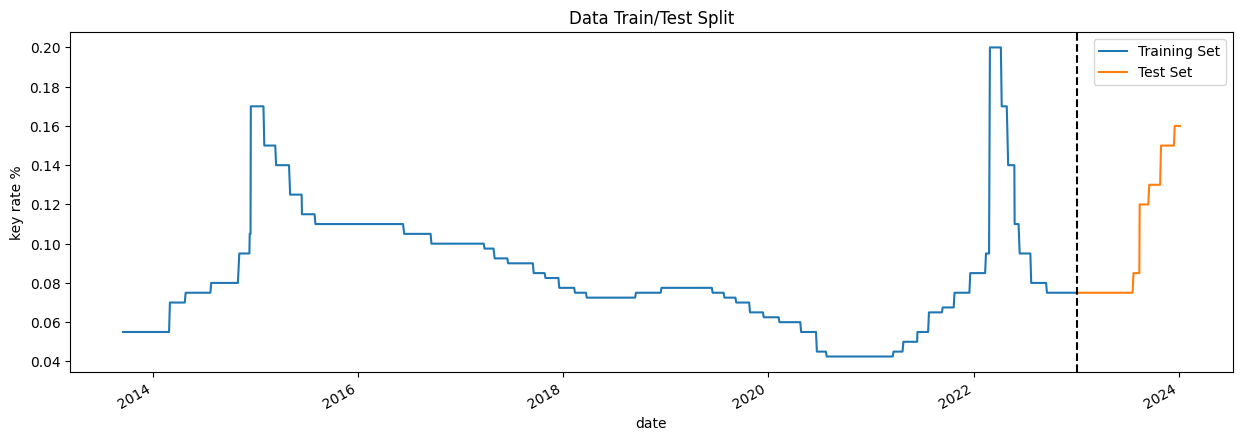

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))

train_df.set_index("ds").plot(ax = ax,
                              label = "Train",
                              title = "Data Train/Test Split")
test_df.set_index("ds").plot(ax = ax, label = "Test")
ax.axvline(train_df["ds"][-1:].values, color = "black", ls = "--")
ax.legend(["Training Set", "Test Set"])
ax.set_ylabel("key rate %")
ax.set_xlabel("date")
plt.show()

In [ ]:
%%time

model = Prophet(changepoint_prior_scale = 0.3)
model.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp58jd22s3/jmsle9sk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp58jd22s3/4dwapxq0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18934', 'data', 'file=/tmp/tmp58jd22s3/jmsle9sk.json', 'init=/tmp/tmp58jd22s3/4dwapxq0.json', 'output', 'file=/tmp/tmp58jd22s3/prophet_model23djtlpn/prophet_model-20240108153911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 445 ms, sys: 46.2 ms, total: 491 ms
Wall time: 2.7 s


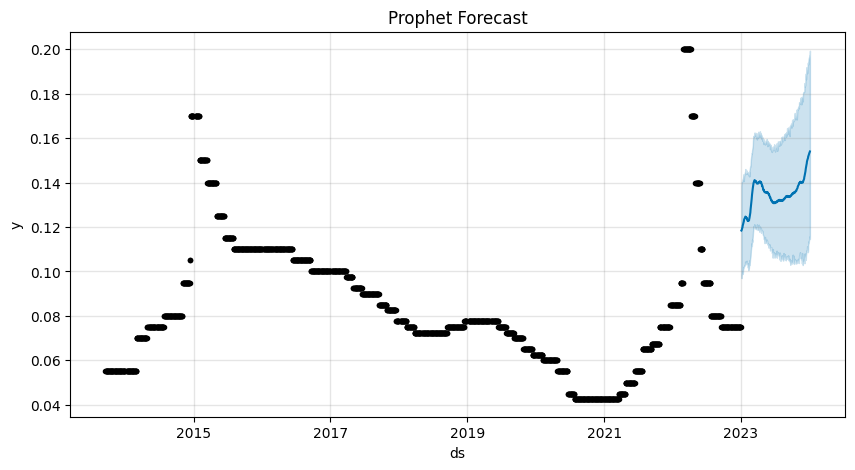

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
predict = model.predict(test_df)
fig = model.plot(predict, ax = ax)
ax.set_title("Prophet Forecast")
plt.show()

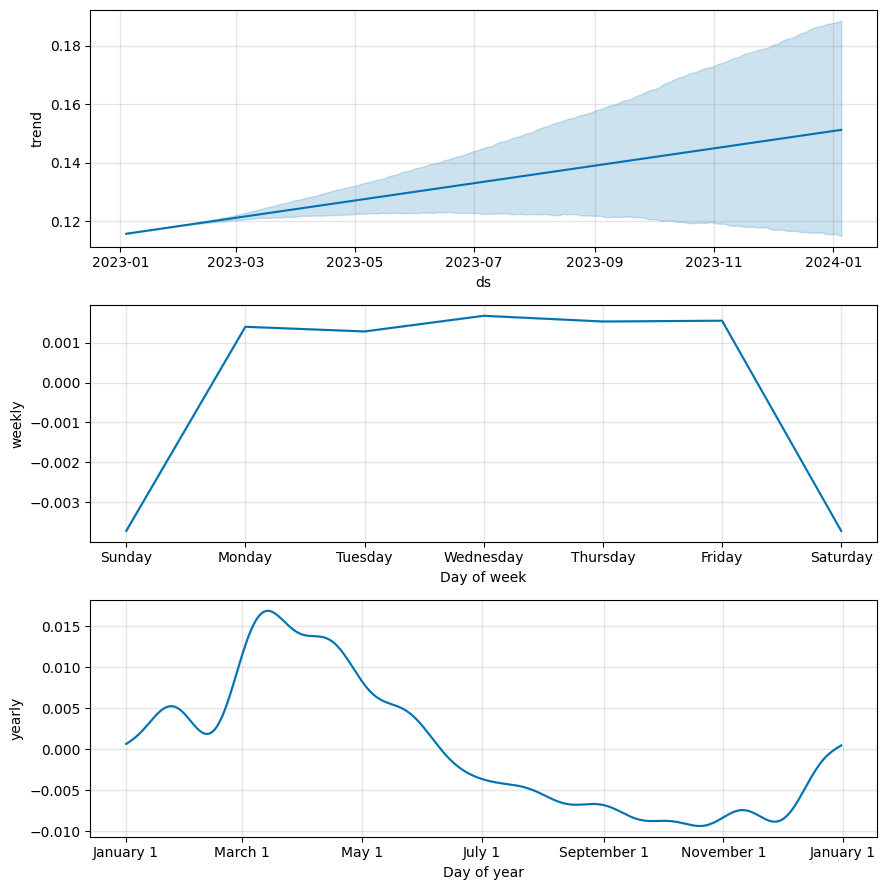

In [ ]:
fig = model.plot_components(predict)
plt.show()

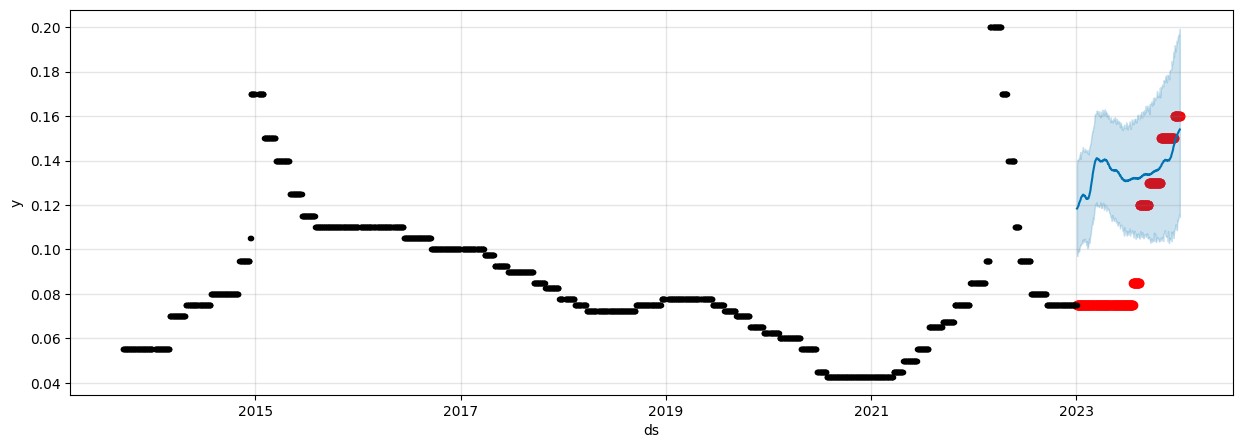

In [ ]:
f, ax = plt.subplots(figsize = (15, 5))

ax.scatter(test_df.ds, test_df["y"], color = "r")
fig = model.plot(predict, ax = ax)

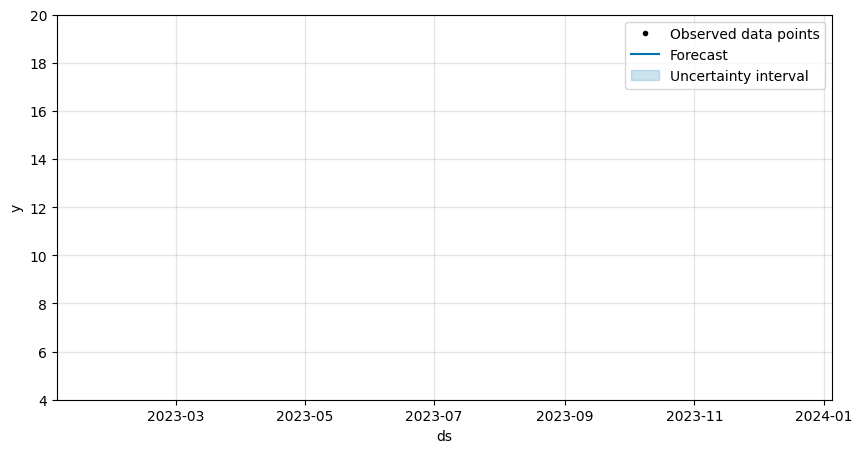

In [ ]:
'''
f, ax = plt.subplots(figsize = (10, 5))

ax.scatter(test_df.ds, test_df["y"], color = "r")
fig = model.plot(predict, ax = ax)
ax.set_xbound(lower = test_df["ds"][:1].values,
              upper = test_df["ds"][-1:].values)
ax.set_ylim(4, 20)
ax.legend()
plt.show()

In [ ]:
df_test_null = test_df.copy()
df_test_null["y"] = None

df_predict = pd.concat([train_df, df_test_null])
predict = model.predict(df_predict)

In [ ]:
mean_absolute_error(y_true = test_df["y"],
                    y_pred = predict["yhat"][train_df.shape[0]:])


0.037407225538217286

In [ ]:
mean_absolute_percentage_error(y_true = test_df["y"],
                               y_pred = predict["yhat"][train_df.shape[0]:])

0.4730741427854226

In [ ]:
%%time

model_full = Prophet()
model_full.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp58jd22s3/1x7mf81s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp58jd22s3/loe2vljp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34341', 'data', 'file=/tmp/tmp58jd22s3/1x7mf81s.json', 'init=/tmp/tmp58jd22s3/loe2vljp.json', 'output', 'file=/tmp/tmp58jd22s3/prophet_model6zxc7436/prophet_model-20240108160429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:04:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:04:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 179 ms, sys: 9.76 ms, total: 189 ms
Wall time: 664 ms


In [ ]:
future = model_full.make_future_dataframe(periods = 200, freq = "D")
forecast = model_full.predict(future)

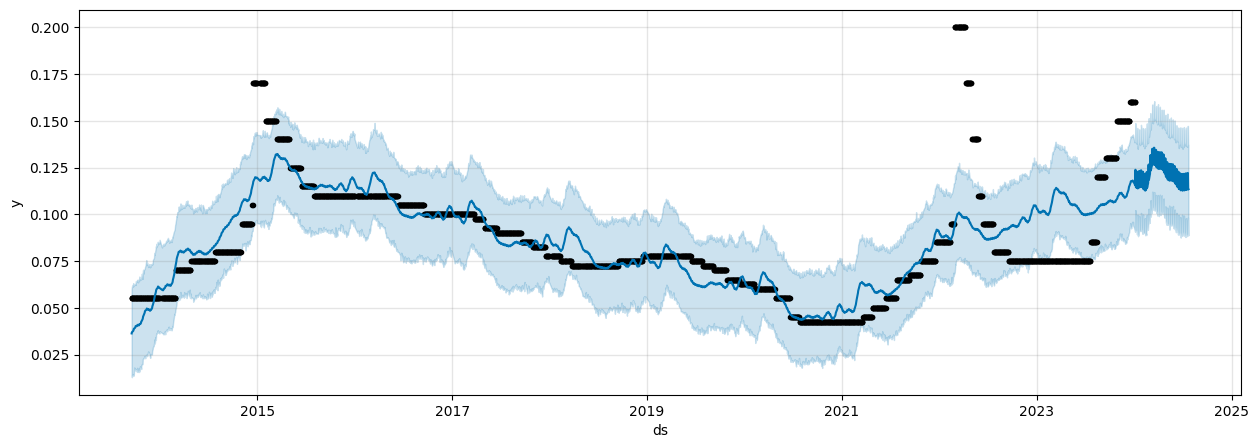

In [ ]:
f, ax = plt.subplots(figsize = (15,5))
fig = model_full.plot(forecast, ax = ax)

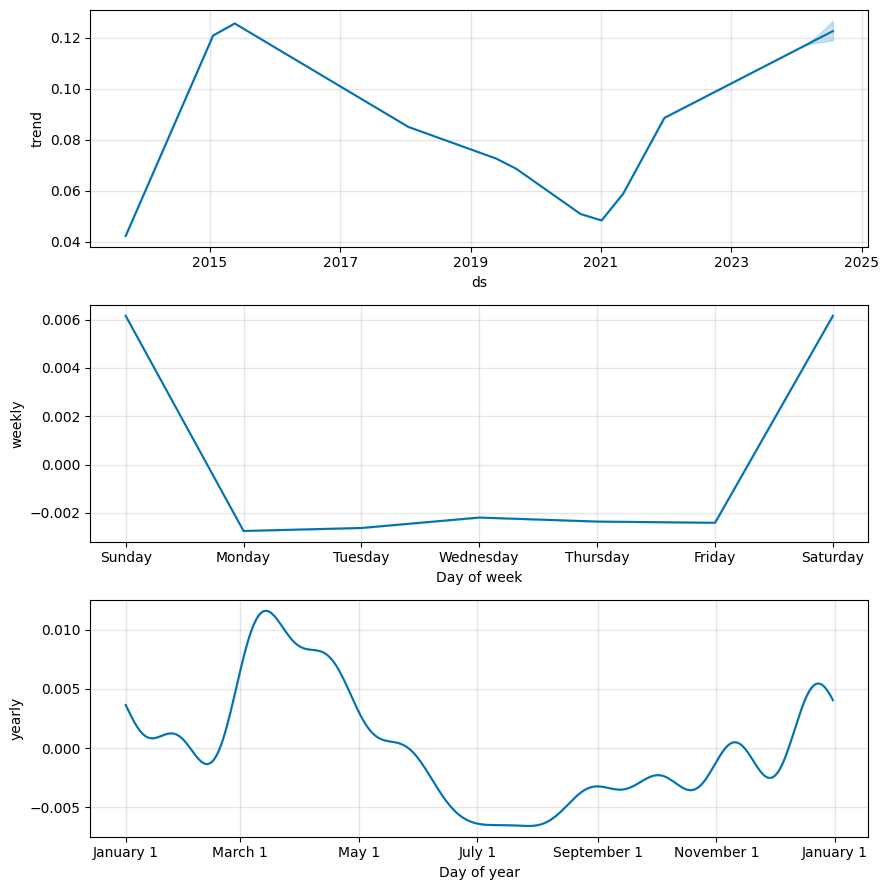

In [ ]:
fig = model_full.plot_components(forecast)
plt.show()